In [30]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs

device = 'cpu'

In [31]:
param_regex = 'pos(.*)_neg(.*)'
gridsearch_dir = f"{configs.engram_dir}01_tau_gridsearch/"
gridsearch_dir = "../trained_models/01_tau_gridsearch_approxBFalse/"
tau_neg_axes = []
tau_pos_axes = []
vals = []
val_means = []
A_poses = []
A_negs = []
results = {
    'tau_neg_axes': tau_neg_axes,
    'tau_pos_axes': tau_pos_axes,
    'vals': vals,
    'A_poses': A_poses,
    'A_negs': A_negs
}
for d in os.listdir(gridsearch_dir):
    param_match = re.search(param_regex, d)
    if param_match is None: continue
    tau_pos_ax = float(param_match.group(1))
    tau_neg_ax = float(param_match.group(2))
    tau_pos_axes.append(tau_pos_ax)
    tau_neg_axes.append(tau_neg_ax)
        
    val = np.inf
    A_pos = np.nan
    A_neg = np.nan
    all_vals = []
    for file in os.listdir(gridsearch_dir + d):
        if 'tfevents' not in file: continue
        tfevents_file = gridsearch_dir + d + '/' + file
        event_acc = EventAccumulator(tfevents_file)
        event_acc.Reload()
        try:
            _val = event_acc.Scalars('loss_train')[-1].value
        except:
            continue
        model_file = gridsearch_dir + d + '/' + 'model.pt'
        state_dict = torch.load(model_file)
        _A_pos = abs(state_dict['ca3.A_pos'])
        _A_neg = abs(state_dict['ca3.A_neg'])
        _neg_coeff = _A_neg*10*np.exp(-1/abs(tau_neg_ax))
        _pos_coeff = _A_pos*10*np.exp(-1/abs(tau_pos_ax))
#         if not (_neg_coeff < 0.1 or _pos_coeff < 0.1): # TODO: remove?
#             all_vals.append(_val)
        
        # For finding the max
        if _val < val:
            val = _val    
            A_pos = _A_pos
            A_neg = _A_neg
    vals.append(val)
    val_means.append(np.mean(all_vals))
    A_poses.append(A_pos)
    A_negs.append(A_neg)

In [32]:
tau_neg_axes = np.array(results['tau_neg_axes'])
tau_pos_axes = np.array(results['tau_pos_axes'])
tau_neg_unique = np.sort(np.unique(tau_neg_axes))
tau_pos_unique = np.sort(np.unique(tau_pos_axes))

# Plot errors where scaling factors is sufficient

In [33]:
Aneg_coeff_mat = np.zeros((tau_neg_unique.size, tau_pos_unique.size))*np.nan
for tau_neg_ax, tau_pos_ax, A_neg in zip(
    results['tau_neg_axes'], results['tau_pos_axes'], results['A_negs']
    ):
    x_idx = np.argwhere(tau_neg_unique == tau_neg_ax)[0,0]
    y_idx = np.argwhere(tau_pos_unique == tau_pos_ax)[0,0]
    Aneg_coeff_mat[x_idx][y_idx] = A_neg*10*np.exp(-1/abs(tau_neg_ax))

In [34]:
Apos_coeff_mat = np.zeros((tau_neg_unique.size, tau_pos_unique.size))*np.nan
for tau_neg_ax, tau_pos_ax, A_pos in zip(
    results['tau_neg_axes'], results['tau_pos_axes'], results['A_poses']
    ):
    x_idx = np.argwhere(tau_neg_unique == tau_neg_ax)[0,0]
    y_idx = np.argwhere(tau_pos_unique == tau_pos_ax)[0,0]
    Apos_coeff_mat[x_idx][y_idx] = A_pos*10*np.exp(-1/abs(tau_pos_ax))

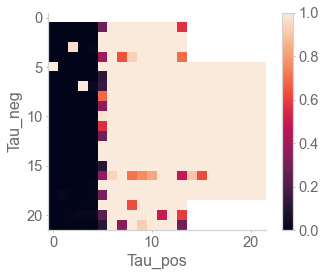

In [35]:
plt.figure()
plt.imshow(Apos_coeff_mat, vmax=1)
# plt.yticks(np.arange(tau_neg_unique.size), [f'{x:.2f}' for x in tau_neg_unique])
# plt.xticks(
#     np.arange(tau_pos_unique.size), [f'{y:.2f}' for y in tau_pos_unique],
#     rotation=45
#     )
plt.xlabel('Tau_pos')
plt.ylabel('Tau_neg')
plt.colorbar()
plt.show()

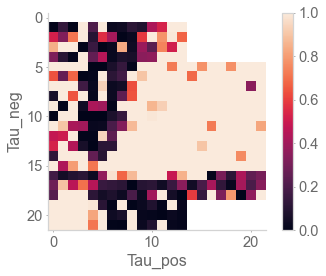

In [36]:
plt.figure()
plt.imshow(Aneg_coeff_mat, vmax=1)
# plt.yticks(np.arange(xs.size), [f'{x:.2f}' for x in xs])
# plt.xticks(
#     np.arange(ys.size), [f'{y:.2f}' for y in ys],
#     rotation=45
#     )
plt.xlabel('Tau_pos')
plt.ylabel('Tau_neg')
plt.colorbar()
plt.show()

In [37]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_32808/3549712815.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


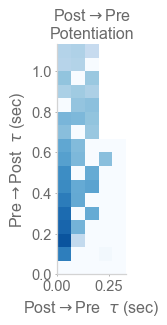

In [69]:
coeff_threshold = 0.1
vmax = 0.03#0.025

# Collect values
mat = np.zeros((tau_neg_unique.size, tau_pos_unique.size))*np.nan
for tau_neg_ax, tau_pos_ax, val in zip(
    results['tau_neg_axes'], results['tau_pos_axes'], results['vals']
    ):
    x_idx = np.argwhere(tau_neg_unique == tau_neg_ax)[0,0]
    y_idx = np.argwhere(tau_pos_unique == tau_pos_ax)[0,0]
    mat[x_idx][y_idx] = val

# "Zero"-out entries where coefficient approaches zero
mat[Aneg_coeff_mat<coeff_threshold] = vmax
mat[Apos_coeff_mat<coeff_threshold] = vmax

x_list = tau_neg_unique #np.sort(np.unique(xs))
y_list = tau_pos_unique #np.sort(np.unique(ys))
x, y = np.meshgrid(x_list/configs.dt_to_sec, y_list/configs.dt_to_sec)

fig, ax = plt.subplots(figsize=(6.4*(1./3.), 4.8))
im = ax.pcolormesh(
    x, y, mat.T, cmap="Blues_r",
    vmax=vmax, vmin=0
    )

plt.xlim(0) #-4/configs.dt_to_sec, 2./configs.dt_to_sec)
plt.ylim(0)
plt.xlabel('Post$\\rightarrow$Pre  $\\tau$ (sec)')
plt.ylabel('Pre$\\rightarrow$Post  $\\tau$ (sec)')
plt.title("Post$\\rightarrow$Pre\nPotentiation")
plt.tight_layout()
plt.savefig("tau_grid_mse_p2.png", dpi=300)
plt.show()

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_32808/2799845119.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


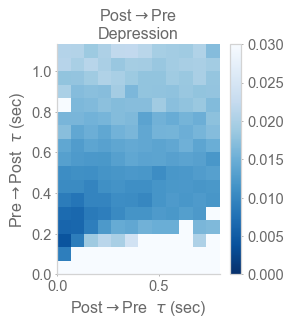

In [70]:
fig, ax = plt.subplots(figsize=(6.4*(2/3.), 4.8))
im = ax.pcolormesh(
    x*-1, y, mat.T, cmap="Blues_r", vmax=vmax, vmin=0
    )
fig.colorbar(im, ax=ax)

plt.xlim(left=0, right=0.8) #-4/configs.dt_to_sec, 2./configs.dt_to_sec)
plt.ylim(0)
plt.xlabel('Post$\\rightarrow$Pre  $\\tau$ (sec)')
plt.ylabel('Pre$\\rightarrow$Post  $\\tau$ (sec)')
plt.title("Post$\\rightarrow$Pre\nDepression")
plt.tight_layout()
plt.savefig("tau_grid_mse_p1.png", dpi=300)
plt.show()